In [ ]:
# ===============================================
# Import Libraries
# ===============================================

import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# =======================================
# Download dataset ZIP
# =======================================

!wget https://huggingface.co/datasets/amdmqd/rice_leaf_disease_dataset/resolve/main/rice_leaf_disease_dataset.zip

!unzip rice_leaf_disease_dataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: rice_leaf_disease_dataset/Blast/BLAST8_094.jpg  
  inflating: rice_leaf_disease_dataset/Blast/BLAST8_095.jpg  
  inflating: rice_leaf_disease_dataset/Blast/BLAST8_096.jpg  
  inflating: rice_leaf_disease_dataset/Blast/BLAST8_097.jpg  
  inflating: rice_leaf_disease_dataset/Blast/BLAST8_098.jpg  
  inflating: rice_leaf_disease_dataset/Blast/BLAST8_099.jpg  
  inflating: rice_leaf_disease_dataset/Blast/BLAST8_100.jpg  
  inflating: rice_leaf_disease_dataset/Blast/BLAST8_101.jpg  
  inflating: rice_leaf_disease_dataset/Blast/BLAST8_102.jpg  
  inflating: rice_leaf_disease_dataset/Blast/BLAST8_103.jpg  
  inflating: rice_leaf_disease_dataset/Blast/BLAST8_104.jpg  
  inflating: rice_leaf_disease_dataset/Blast/BLAST8_105.jpg  
  inflating: rice_leaf_disease_dataset/Blast/BLAST8_106.jpg  
  inflating: rice_leaf_disease_dataset/Blast/BLAST8_107.jpg  
  inflating: rice_leaf_disease_dataset/Blast/BLAST8_108.jpg  
  inflating

In [ ]:
# =======================================
# Split Train and Test
# =======================================

SOURCE_DIR = 'rice_leaf_disease_dataset'
OUTPUT_DIR = 'rice_leaf_disease_dataset_split'

train_split = 0.7
val_split = 0.15
test_split = 0.15

for split in ['train', 'val', 'test']:
  os.makedirs(os.path.join(OUTPUT_DIR, split), exist_ok=True)

for class_name in (os.listdir(SOURCE_DIR)):
  class_path = os.path.join(SOURCE_DIR, class_name)
  if not os.path.isdir(class_path):
    continue

  images = os.listdir(class_path)
  random.shuffle(images)

  train_size = int(train_split * len(images))
  val_size = train_size + int(val_split * len(images))

  splits = {
      'train' : images[:train_size],
      'val' : images[train_size:val_size],
      'test' : images[val_size:]
  }

  for split, files in splits.items():
    split_dir = os.path.join(OUTPUT_DIR, split, class_name)
    os.makedirs(split_dir, exist_ok=True)

    for file in files:
      shutil.copy(os.path.join(class_path, file), os.path.join(split_dir, file))

print("[INFO] Split Dataset Into : ", OUTPUT_DIR)

[INFO] Split Dataset Into :  rice_leaf_disease_dataset_split


In [ ]:
# =======================================
# Image Data Generator
# =======================================

IMG_SIZE = (180, 180)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(OUTPUT_DIR, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = train_datagen.flow_from_directory(
    os.path.join(OUTPUT_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(OUTPUT_DIR, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 5453 images belonging to 5 classes.
Found 1173 images belonging to 5 classes.
Found 1168 images belonging to 5 classes.


In [ ]:
# =======================================
# CNN Model
# =======================================

model = models.Sequential([
    layers.Input(shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0, 3),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# =======================================
# Callbacks
# =======================================

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks_list = [early_stop, reduce_lr, checkpoint]


In [ ]:
# =======================================
# Training
# =======================================

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.5087 - loss: 1.3229
Epoch 1: val_loss improved from inf to 0.60005, saving model to best_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 68s 356ms/step - accuracy: 0.5094 - loss: 1.3207 - val_accuracy: 0.7791 - val_loss: 0.6000 - learning_rate: 0.0010
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7873 - loss: 0.5891
Epoch 2: val_loss improved from 0.60005 to 0.47779, saving model to best_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 54s 314ms/step - accuracy: 0.7873 - loss: 0.5889 - val_accuracy: 0.8048 - val_loss: 0.4778 - learning_rate: 0.0010
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8235 - loss: 0.4525
Epoch 3: val_loss improved from 0.47779 to 0.31903, saving model to best_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 56s 326ms/step - accuracy: 0.8236 - loss: 0.4523 - val_accuracy: 0.8699 - val_loss: 0.3190 - learning_rate: 0.0010
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.8795 - loss: 0.3213
Epoch 4: val_loss improved from 0.31903 to 0.29913, saving model to best_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 54s 314ms/step - accuracy: 0.8794 - loss: 0.3214 - val_accuracy: 0.8853 - val_loss: 0.2991 - learning_rate: 0.0010
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8987 - loss: 0.2654
Epoch 5: val_loss improved from 0.29913 to 0.21464, saving model to best_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 54s 315ms/step - accuracy: 0.8987 - loss: 0.2654 - val_accuracy: 0.9247 - val_loss: 0.2146 - learning_rate: 0.0010
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9019 - loss: 0.2579
Epoch 6: val_loss did not improve from 0.21464
171/171 ━━━━━━━━━━━━━━━━━━━━ 82s 317ms/step - accuracy: 0.9019 - loss: 0.2578 - val_accuracy: 0.9092 - val_loss: 0.2298 - learning_rate: 0.0010
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9300 - loss: 0.2009
Epoch 7: val_loss improved from 0.21464 to 0.16331, saving model to best_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 320ms/step - accuracy: 0.9300 - loss: 0.2008 - val_accuracy: 0.9409 - val_loss: 0.1633 - learning_rate: 0.0010
Epoch 8/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9417 - loss: 0.1632
Epoch 8: val_loss did not improve from 0.16331
171/171 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - accuracy: 0.9417 - loss: 0.1633 - val_accuracy: 0.9229 - val_loss: 0.1977 - learning_rate: 0.0010
Epoch 9/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9336 - loss: 0.1805
Epoch 9: val_loss improved from 0.16331 to 0.14567, saving model to best_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 56s 329ms/step - accuracy: 0.9336 - loss: 0.1804 - val_accuracy: 0.9366 - val_loss: 0.1457 - learning_rate: 0.0010
Epoch 10/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9340 - loss: 0.1728
Epoch 10: val_loss did not improve from 0.14567
171/171 ━━━━━━━━━━━━━━━━━━━━ 53s 309ms/step - accuracy: 0.9340 - loss: 0.1728 - val_accuracy: 0.9409 - val_loss: 0.1537 - learning_rate: 0.0010
Epoch 11/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9493 - loss: 0.1382
Epoch 11: val_loss improved from 0.14567 to 0.12082, saving model to best_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 53s 310ms/step - accuracy: 0.9493 - loss: 0.1382 - val_accuracy: 0.9632 - val_loss: 0.1208 - learning_rate: 0.0010
Epoch 12/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9568 - loss: 0.1089
Epoch 12: val_loss did not improve from 0.12082
171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 320ms/step - accuracy: 0.9567 - loss: 0.1090 - val_accuracy: 0.9572 - val_loss: 0.1217 - learning_rate: 0.0010
Epoch 13/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9601 - loss: 0.1020
Epoch 13: val_loss improved from 0.12082 to 0.11338, saving model to best_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - accuracy: 0.9601 - loss: 0.1021 - val_accuracy: 0.9658 - val_loss: 0.1134 - learning_rate: 0.0010
Epoch 14/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9648 - loss: 0.0965
Epoch 14: val_loss improved from 0.11338 to 0.08040, saving model to best_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 323ms/step - accuracy: 0.9648 - loss: 0.0965 - val_accuracy: 0.9752 - val_loss: 0.0804 - learning_rate: 0.0010
Epoch 15/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9649 - loss: 0.0967
Epoch 15: val_loss did not improve from 0.08040
171/171 ━━━━━━━━━━━━━━━━━━━━ 54s 315ms/step - accuracy: 0.9649 - loss: 0.0967 - val_accuracy: 0.9735 - val_loss: 0.0870 - learning_rate: 0.0010
Epoch 16/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9568 - loss: 0.1124
Epoch 16: val_loss did not improve from 0.08040
171/171 ━━━━━━━━━━━━━━━━━━━━ 53s 309ms/step - accuracy: 0.9568 - loss: 0.1126 - val_accuracy: 0.9640 - val_loss: 0.1110 - learning_rate: 0.0010
Epoch 17/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9771 - loss: 0.0641
Epoch 17: val_loss improved from 0.08040 to 0.07214, saving model to best_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 319ms/step - accuracy: 0.9771 - loss: 0.0640 - val_accuracy: 0.9760 - val_loss: 0.0721 - learning_rate: 0.0010
Epoch 18/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9778 - loss: 0.0758
Epoch 18: val_loss did not improve from 0.07214
171/171 ━━━━━━━━━━━━━━━━━━━━ 54s 315ms/step - accuracy: 0.9778 - loss: 0.0758 - val_accuracy: 0.9735 - val_loss: 0.0743 - learning_rate: 0.0010
Epoch 19/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9781 - loss: 0.0709
Epoch 19: val_loss did not improve from 0.07214
171/171 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - accuracy: 0.9781 - loss: 0.0709 - val_accuracy: 0.9658 - val_loss: 0.1121 - learning_rate: 0.0010
Epoch 20/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9750 - loss: 0.0755
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 20: val_loss did not improve from 0.07214
171/171 ━━━━━━━━━━━━━━━━━━━━ 82s 312ms/step - accuracy: 0.9750 - loss: 0.0755 

In [ ]:
# =======================================
# Evaluasi Model
# =======================================

best_model = load_model('best_model.h5')

test_loss, test_acc = best_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 304ms/step - accuracy: 0.9703 - loss: 0.1228
Test Accuracy: 0.9795


In [ ]:
# =======================================
# Classification Report
# =======================================

y_pred = np.argmax(best_model.predict(test_generator), axis=-1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step
                 precision    recall  f1-score   support

Bacterialblight       0.95      0.98      0.97       239
          Blast       0.95      0.93      0.94       217
      Brownspot       0.99      0.97      0.98       240
        Healthy       1.00      1.00      1.00       280
         Tungro       0.99      1.00      1.00       197

       accuracy                           0.98      1173
      macro avg       0.98      0.98      0.98      1173
   weighted avg       0.98      0.98      0.98      1173



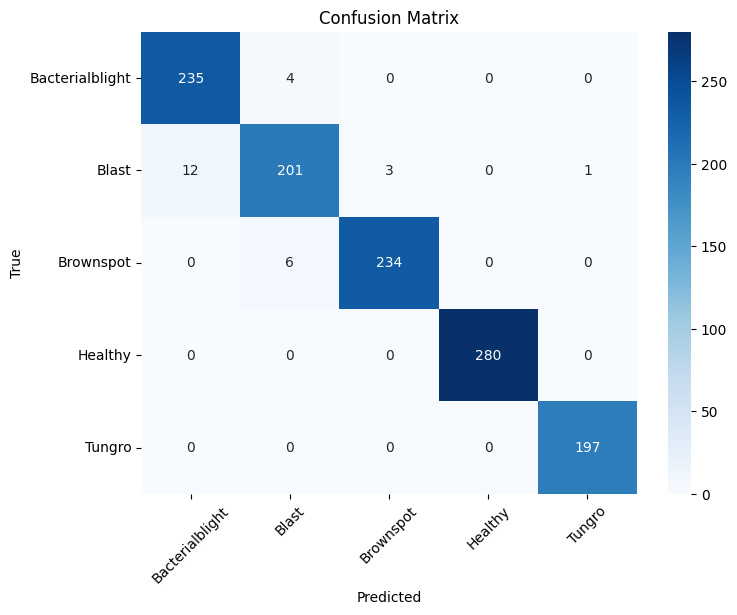

In [ ]:
# =======================================
# Confussion Matrix
# =======================================

cm = confusion_matrix(y_true, y_pred)

# Class Name
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Configure label for X axis and Y axis
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=45)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Per-Class Accuracy = Sum of correct prediction for class i / total actual instance from class i
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

class_names = list(test_generator.class_indices.keys())

for i, acc in enumerate(per_class_accuracy):
    print(f"Accuration of {class_names[i]}: {acc:.2f}")

Accuration of Bacterialblight: 0.98
Accuration of Blast: 0.93
Accuration of Brownspot: 0.97
Accuration of Healthy: 1.00
Accuration of Tungro: 1.00


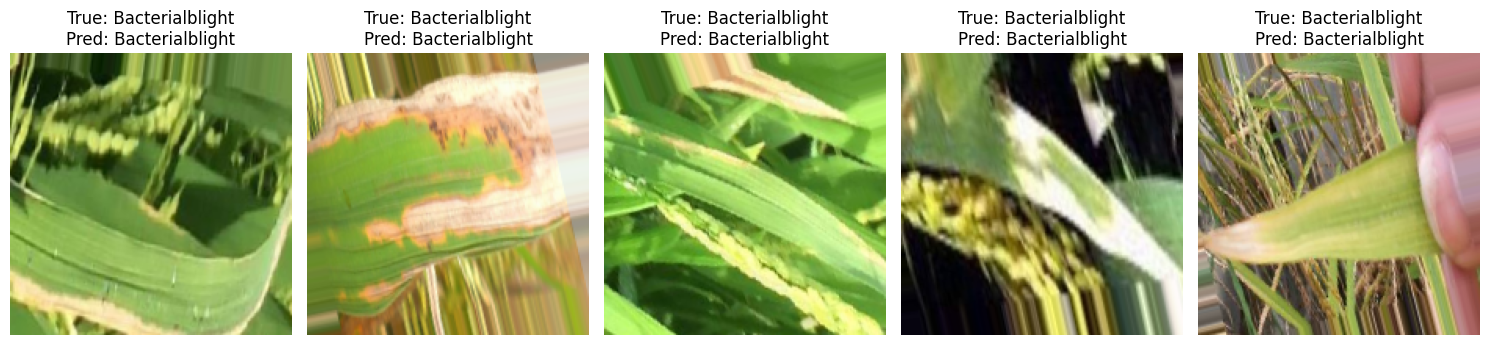

In [ ]:
# Get batch of images from validation generator
images, labels = next(test_generator)

# Class name mapping
class_names = list(test_generator.class_indices.keys())

# Plot size
plt.figure(figsize=(15, 8))

# Get 5 random images and show
for i in range(5):
    idx = random.randint(0, len(images) - 1)
    img = images[idx]
    true_label = np.argmax(labels[idx])

    # Predict
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_label = np.argmax(pred)

    # Plot
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


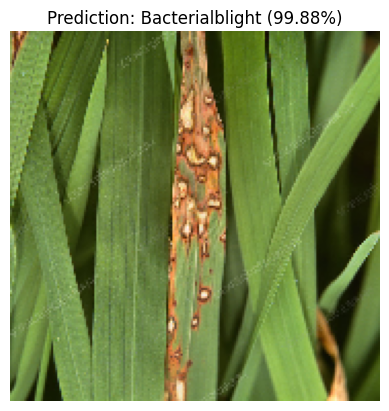

In [ ]:
# === CONFIGURATION ===
MODEL_PATH = "best_model.h5"
IMG_PATH = "test_images/image1.jpg"  # Change to your test image
CLASS_NAMES = list(test_generator.class_indices.keys())  # Get class name from test generator
IMG_SIZE = (180, 180)

# === LOAD MODEL ===
model = tf.keras.models.load_model(MODEL_PATH)

# === LOAD & PREPROCESS IMAGE ===
img = image.load_img(IMG_PATH, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalization
img_array = np.expand_dims(img_array, axis=0)

# === PREDICT ===
pred = model.predict(img_array)
predicted_class = CLASS_NAMES[np.argmax(pred)]
confidence = np.max(pred) * 100

# === OUTPUT ===
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
plt.show()